# Test time series forecasting
- Test different time series forecasting methods to be able to predict the future values of the explanatory variables

1. Find different methods and select the best one
    - Is there a method that could forecast each variable based on history of this variable and the history of other variables?
2. For each explanatory variable:
    - Divide the data into train and test sets (e.g. train 2015-2020, test 2021 and 2022)
    - Train the model to predict the future values based on the history
    - Test the predidctions compared to the actual values
3. Use the data forecasted by these models in the price regression

In [18]:
import pandas as pd

In [19]:
df = pd.read_csv('./data/full_dataset.csv')

In [20]:
df.head()

,Unnamed: 0,Area,MTU,Biomass - Actual Aggregated [MW],Fossil Gas - Actual Aggregated [MW],Fossil Hard coal - Actual Aggregated [MW],Fossil Oil - Actual Aggregated [MW],Fossil Peat - Actual Aggregated [MW],Hydro Run-of-river and poundage - Actual Aggregated [MW],Nuclear - Actual Aggregated [MW],...,Day-ahead Total Load Forecast [MW] - BZN|FI,Actual Total Load [MW] - BZN|FI,MTU (CET/CEST),Day-ahead Price [EUR/MWh],Currency,start_time,end_time,generation_total,date,price_per_gallon_dollars
0,0,BZN|FI,02.01.2015 00:00 - 02.01.2015 01:00,881.0,700.0,686.0,1.0,428.0,622.0,2773.0,...,9116.0,8956.0,02.01.2015 00:00 - 02.01.2015 01:00,17.78,EUR,2015-01-02 00:00:00,2015-01-02 01:00:00,6640.0,2015-01-02,52.72
1,1,BZN|FI,02.01.2015 01:00 - 02.01.2015 02:00,884.0,696.0,684.0,1.0,422.0,583.0,2773.0,...,8892.0,8721.0,02.01.2015 01:00 - 02.01.2015 02:00,9.62,EUR,2015-01-02 01:00:00,2015-01-02 02:00:00,6599.0,2015-01-02,52.72
2,2,BZN|FI,02.01.2015 02:00 - 02.01.2015 03:00,897.0,691.0,683.0,1.0,422.0,538.0,2774.0,...,8810.0,8662.0,02.01.2015 02:00 - 02.01.2015 03:00,7.67,EUR,2015-01-02 02:00:00,2015-01-02 03:00:00,6520.0,2015-01-02,52.72
3,3,BZN|FI,02.01.2015 03:00 - 02.01.2015 04:00,898.0,696.0,687.0,1.0,417.0,545.0,2774.0,...,8860.0,8739.0,02.01.2015 03:00 - 02.01.2015 04:00,10.83,EUR,2015-01-02 03:00:00,2015-01-02 04:00:00,6548.0,2015-01-02,52.72
4,4,BZN|FI,02.01.2015 04:00 - 02.01.2015 05:00,898.0,704.0,693.0,1.0,423.0,633.0,2774.0,...,9202.0,9006.0,02.01.2015 04:00 - 02.01.2015 05:00,23.14,EUR,2015-01-02 04:00:00,2015-01-02 05:00:00,6681.0,2015-01-02,52.72


## Check for autocorrelation in generation_total

In [6]:
from pandas.plotting import lag_plot

We can plot the observation at the previous time step (t-1) with the observation at the next time step (t+1) as a scatter plot.

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

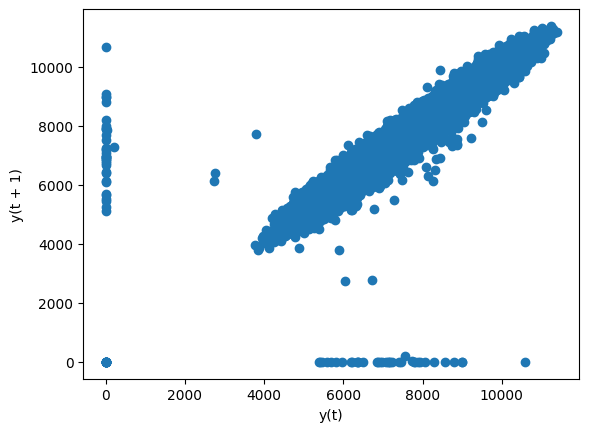

In [14]:
lag_plot(df.loc[:,'generation_total'])

It seems like there is autocorrelation (the value of today depends on the value of yesterday). However, there are a few outliers for which the value of today is above 4500 and the value of yesterdat is 0. Maybe these are the values of the first day in the dataset since there is no data before that point. 

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

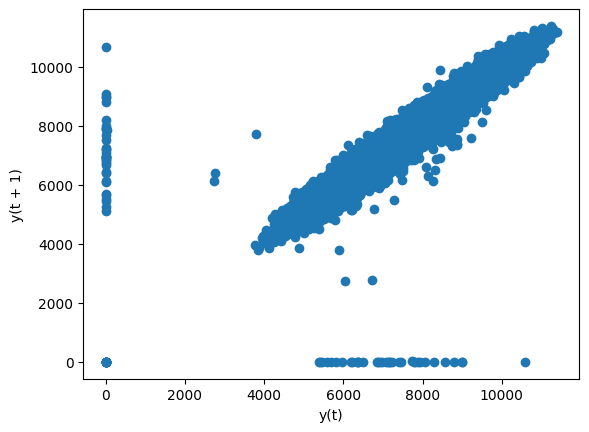

In [24]:
lag_plot(df.loc[(df.date != '2015-01-02') & (df.date != '2022-09-26'),'generation_total'])

It seems like some of the outliers are removed but not all.

## Crude oil price

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

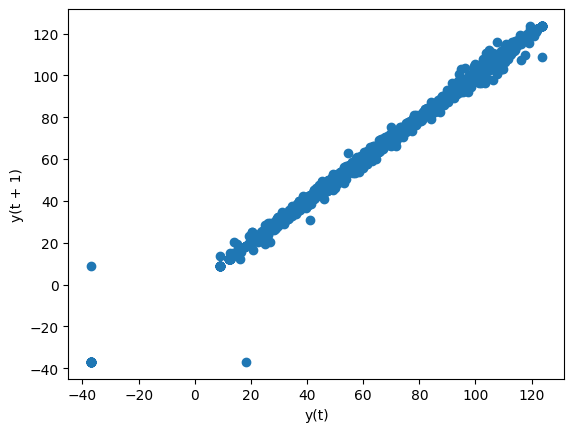

In [25]:
lag_plot(df.loc[:,'price_per_gallon_dollars'])

## Price of electricity

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

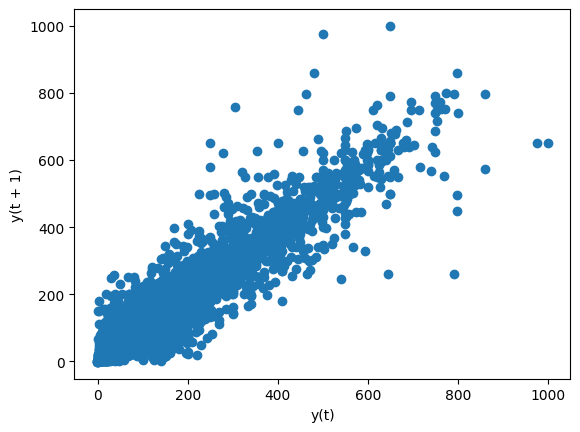

In [26]:
lag_plot(df.loc[:,'Day-ahead Price [EUR/MWh]'])

The day ahead-price seems to depend on the price of the previous day but there is also some noise especially when the prices are high (which they have been during the past year).

<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

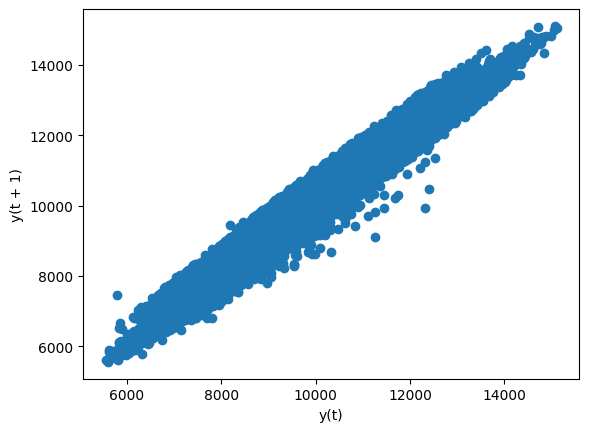

In [28]:
lag_plot(df.loc[:, 'Actual Total Load [MW] - BZN|FI'])

It seems to me that predicting the explanatory variables with a time series forecast might work well but predicting the price of electricity requires another method.

## Split the dataset into train and test

In [40]:
from statsmodels.tsa.ar_model import AutoReg

In [41]:
from sklearn.metrics import mean_squared_error

In [42]:
from math import sqrt

In [30]:
df['date'] = pd.to_datetime(df['date'])

In [36]:
df_train = df.loc[df.date <= pd.Timestamp('2021-12-31')]

In [37]:
df_test = df.loc[df.date > pd.Timestamp('2021-12-31')]

In [43]:
df_train_gen = df_train[['generation_total']]

In [45]:
df_test_gen = df_test[['generation_total']]

In [53]:
#
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series
# data can said to have stationarity
#
from statsmodels.tsa.stattools import adfuller
#
# Run the test
#
df_stationarityTest = adfuller(df['generation_total'], autolag='AIC')
#
# Check the value of p-value
#
print("P-value: ", df_stationarityTest[1])
#
# Next step is to find the order of AR model to be trained
# for this, we will plot partial autocorrelation plot to assess
# the direct effect of past data on future data
#

P-value:  7.532229097776601e-09


The value of generation depends mostly on the value of the past two hours (???). However, there are yearly and monthly variations as well.

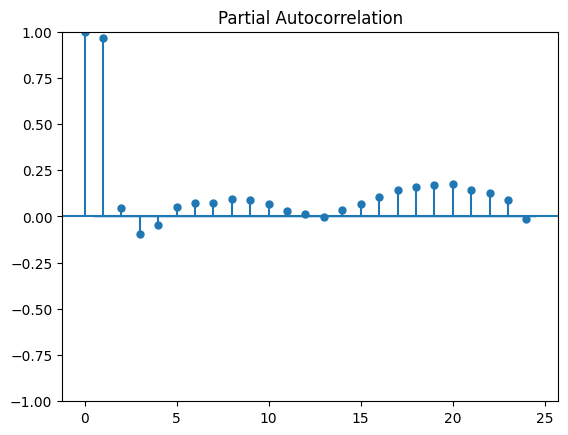

In [69]:

from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(df['generation_total'], lags=24)

In [70]:
ar_model = AutoReg(df_train_gen, lags=24).fit()

In [71]:
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:       generation_total   No. Observations:                43128
Model:                    AutoReg(24)   Log Likelihood             -310605.195
Method:               Conditional MLE   S.D. of innovations            326.037
Date:                Wed, 05 Oct 2022   AIC                         621262.391
Time:                        16:20:38   BIC                         621487.846
Sample:                            24   HQIC                        621333.504
                                43128                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   42.8655      9.302      4.608      0.000      24.634      61.097
generation_total.L1      0.7038      0.005    146.119      0.000       0.694       0.713
generation_t

In [72]:
pred = ar_model.predict(start=len(df_train_gen), end=(len(df)-1), dynamic=False)

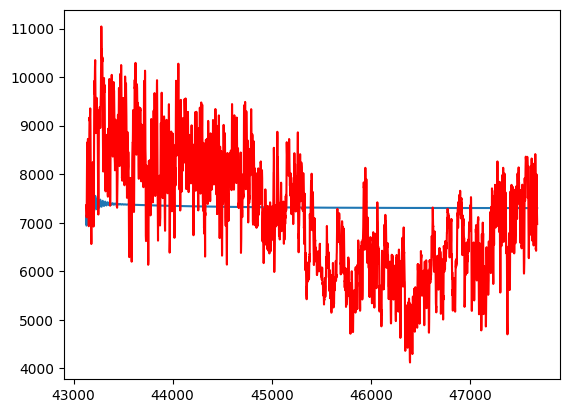

In [73]:
from matplotlib import pyplot
pyplot.plot(pred)
pyplot.plot(df_test_gen, color='red')

This autoregressive model was not able to capture the changes at all.

One explanation could be that the data is too granular for this purpose because we are interested in long-term changes, not hourly changes etc.

## Create daily means to make the data more suitable for the issue

In [75]:
means = df.groupby('date', as_index=False).agg({'Day-ahead Price [EUR/MWh]':'mean', 'Actual Total Load [MW] - BZN|FI':'mean', 'generation_total': 'mean', 'price_per_gallon_dollars':'mean'})

P-value:  0.005239665757205517


/home/hdolivia/.conda/envs/work_env/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


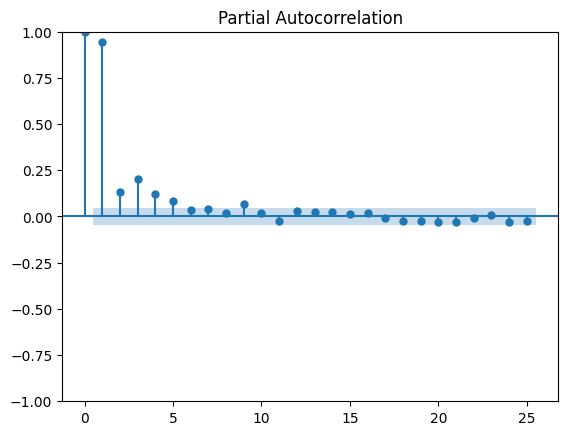

In [76]:
#
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series
# data can said to have stationarity
#
from statsmodels.tsa.stattools import adfuller
#
# Run the test
#
df_stationarityTest = adfuller(means['generation_total'], autolag='AIC')
#
# Check the value of p-value
#
print("P-value: ", df_stationarityTest[1])
#
# Next step is to find the order of AR model to be trained
# for this, we will plot partial autocorrelation plot to assess
# the direct effect of past data on future data
#
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(means['generation_total'], lags=25)

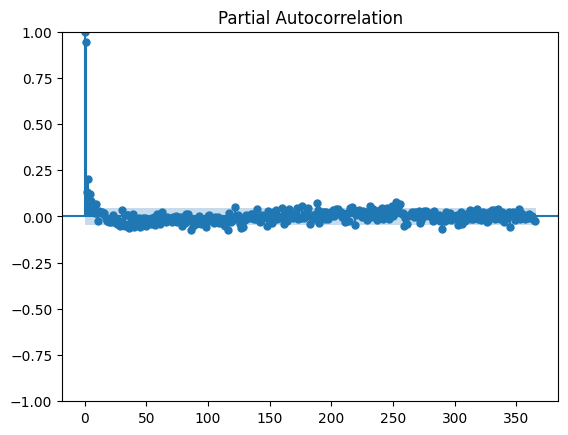

In [77]:
pacf = plot_pacf(means['generation_total'], lags=365)

In [88]:
#
# Create training and test data
#
train_data = means['generation_total'][:len(means)-100]
test_data = means['generation_total'][len(means)-100:]
#
# Instantiate and fit the AR model with training data
#
ar_model = AutoReg(train_data, lags=30).fit()
#
# Print Summary
#
print(ar_model.summary())

                            AutoReg Model Results                             
Dep. Variable:       generation_total   No. Observations:                 1887
Model:                    AutoReg(30)   Log Likelihood              -13650.427
Method:               Conditional MLE   S.D. of innovations            376.854
Date:                Wed, 05 Oct 2022   AIC                          27364.853
Time:                        16:27:27   BIC                          27541.708
Sample:                            30   HQIC                         27430.035
                                 1887                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  228.4641     58.380      3.913      0.000     114.041     342.887
generation_total.L1      0.7411      0.023     31.941      0.000       0.696       0.787
generation_t

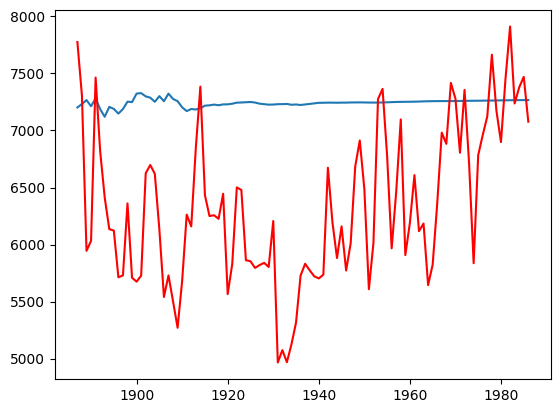

In [89]:

# Make the predictions
#
pred = ar_model.predict(start=len(train_data), end=(len(means)-1), dynamic=False)
#
# Plot the prediction vs test data
#
from matplotlib import pyplot
pyplot.plot(pred)
pyplot.plot(test_data, color='red')

The forecasting method doesn't seem to work at all.

# Try seasonal autoregressive model = SARIMA

The code is from: https://builtin.com/data-science/time-series-forecasting-python

In [98]:
gen = means[['date', 'generation_total']]

In [102]:
gen.set_index('date', inplace = True)

In [92]:
import seaborn as sns

In [94]:
import matplotlib.pyplot as plt

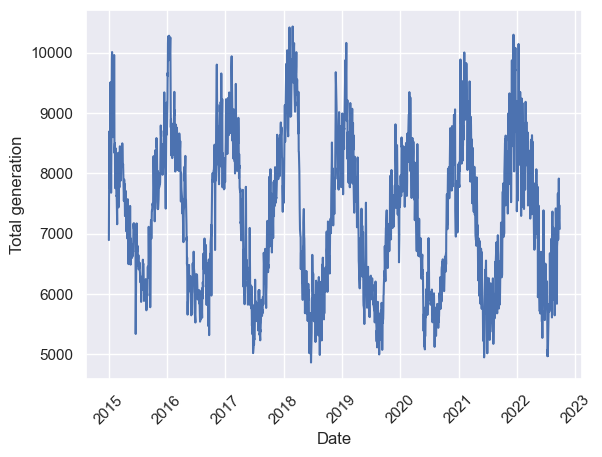

In [103]:
sns.set()
plt.ylabel('Total generation')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.plot(gen.index, gen['generation_total'], )

In [105]:
train = gen[gen.index <= pd.to_datetime("2020-12-31", format='%Y-%m-%d')]
test = gen[gen.index > pd.to_datetime("2020-12-31", format='%Y-%m-%d')]

In [110]:
y = train['generation_total']

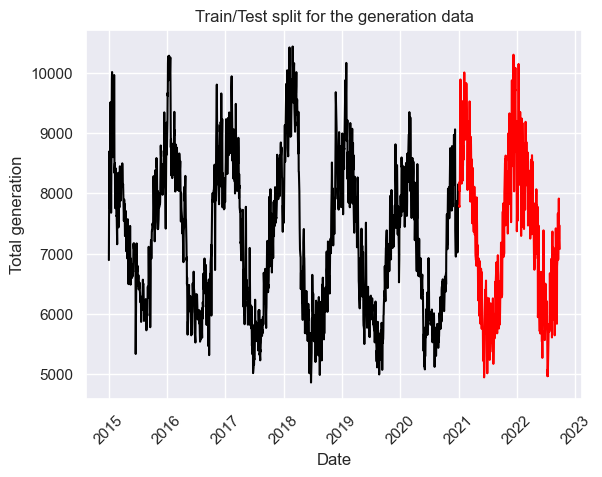

In [106]:
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('Total generation')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for the generation data")
plt.show()

In [122]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [119]:
y = y.asfreq('d')

/home/hdolivia/.conda/envs/work_env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/hdolivia/.conda/envs/work_env/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61785D+05    |proj g|=  1.72331D+06

At iterate    5    f=  1.40275D+04    |proj g|=  1.00320D+04

At iterate   10    f=  2.70082D+03    |proj g|=  1.03811D+03

At iterate   15    f=  4.17742D+02    |proj g|=  3.41920D+02

At iterate   20    f=  6.75466D+01    |proj g|=  1.04675D+02

At iterate   25    f=  1.28924D+01    |proj g|=  4.23522D+00

At iterate   30    f=  6.29421D+00    |proj g|=  3.44476D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/home/hdolivia/.conda/envs/work_env/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   12     34     79      2     0     0   5.833D+05  -0.000D+00
  F =  -0.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              


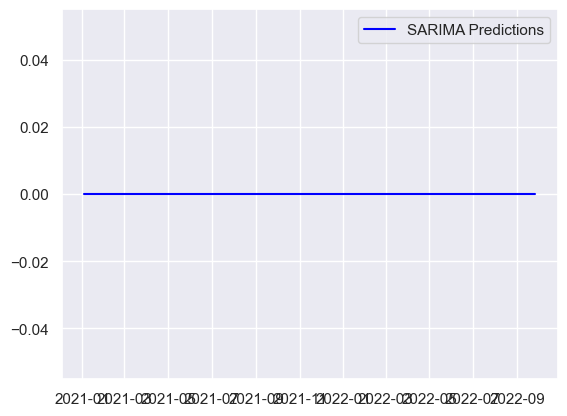

In [120]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.legend()

DatetimeIndex(['2015-01-02', '2015-01-05', '2015-01-06', '2015-01-07',
               '2015-01-08', '2015-01-09', '2015-01-12', '2015-01-13',
               '2015-01-14', '2015-01-15',
               ...
               '2020-12-17', '2020-12-18', '2020-12-21', '2020-12-22',
               '2020-12-23', '2020-12-24', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='date', length=1539, freq=None)

# Try ARIMA model

RMSE:  1472.5763184676352


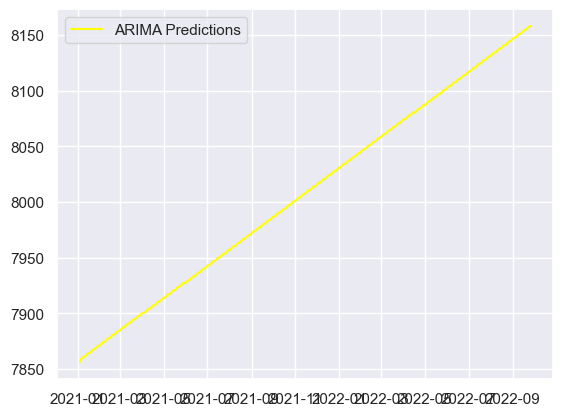

In [124]:
ARIMAmodel = ARIMA(y, order = (2, 2, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Yellow', label = 'ARIMA Predictions')
plt.legend()


import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["generation_total"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)